In [32]:
#https://towardsdatascience.com/music-in-python-2f054deb41f4

In [33]:
%cd harmonics/

[WinError 2] Le fichier spécifié est introuvable: 'harmonics/'
C:\Users\mceau\Documents\harmonics\harmonics


In [199]:
import scipy
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
import pandas as pd
from scipy.signal import find_peaks
import harmonics as h
import audio as a
from importlib import reload
reload(h)
reload(a)
import time
#import pyaudio

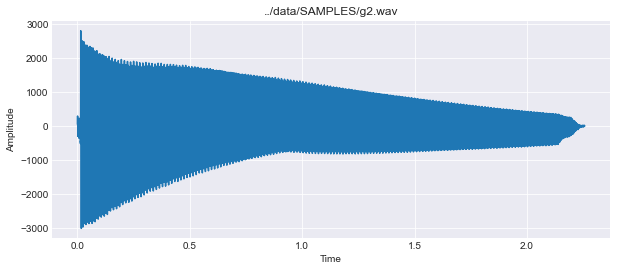

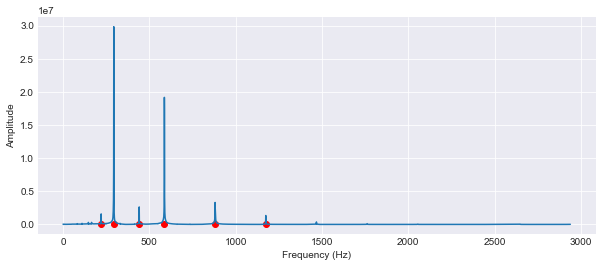

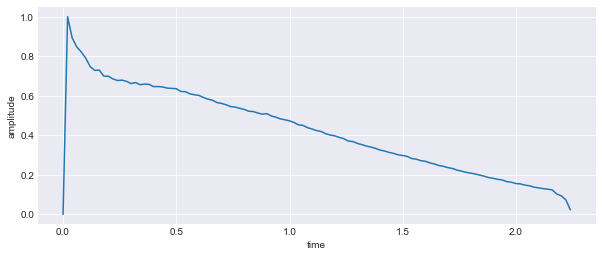

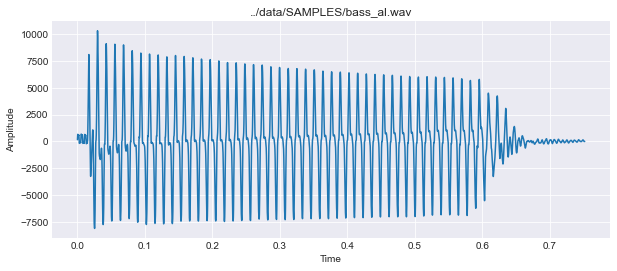

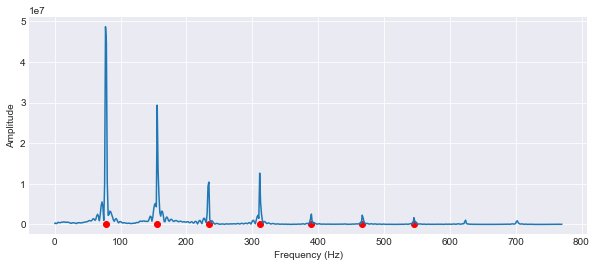

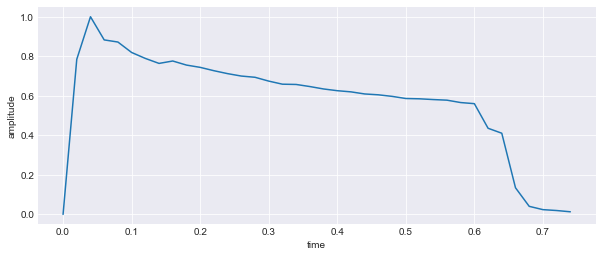

In [200]:
s = a.Sampler()
s.extract('../data/SAMPLES/g2.wav')
s.extract('../data/SAMPLES/bass_al.wav')

extraction took 0.009994983673095703 seconds
extraction took 0.010992765426635742 seconds
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtones
added overtone

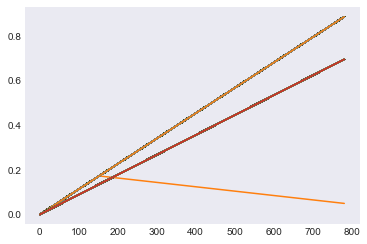

In [201]:
test('milesguitar_mag_phase_no_stretch.wav')

In [148]:
[(a,b) for a,b in s.analyzed.rel_harmonics.values[0]]

[(0.75, 0.05), (1.0, 1.0), (1.5, 0.08), (2.0, 0.98), (3.0, 0.1), (4.0, 0.07)]

In [149]:
s.overtones,s.enveloppe = 0,0

In [150]:
s.frequency = 217

In [190]:
s.amplitude=2000

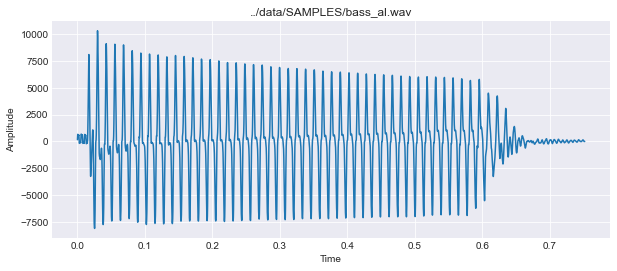

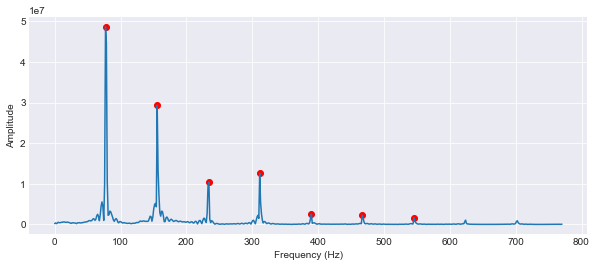

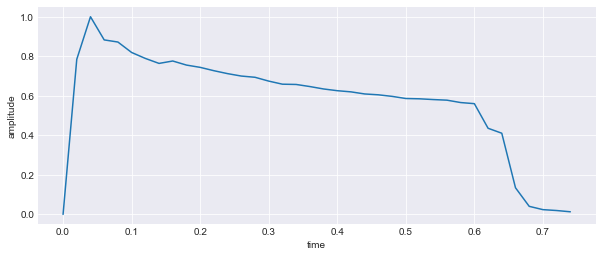

In [94]:
s.df.enveloppe[0]

array([[0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
        0.1       , 0.12      , 0.14      , 0.16      , 0.18      ,
        0.2       , 0.22      , 0.24      , 0.26      , 0.28      ,
        0.3       , 0.32      , 0.34      , 0.36      , 0.38      ,
        0.4       , 0.42      , 0.44      , 0.46      , 0.48      ,
        0.5       , 0.52      , 0.54      , 0.56      , 0.58      ,
        0.6       , 0.62      , 0.64      , 0.66      , 0.68      ,
        0.7       , 0.72      , 0.74      , 0.76      , 0.78      ,
        0.8       , 0.82      , 0.84      , 0.86      , 0.88      ,
        0.9       , 0.92      , 0.94      , 0.96      , 0.98      ,
        1.        , 1.02      , 1.04      , 1.06      , 1.08      ,
        1.1       , 1.12      , 1.14      , 1.16      , 1.18      ,
        1.2       , 1.22      , 1.24      , 1.26      , 1.28      ,
        1.3       , 1.32      , 1.34      , 1.36      , 1.38      ,
        1.4       , 1.42      , 1.44      , 1.46

In [ ]:
w.set_overtones(0)
w.set_enveloppe(False)

In [160]:
w.analyzed

,file,data,rel_harmonics,note,offpitch,enveloppe,frequency,duration
0,../data/g2.wav,"(44100, [52, 66, 80, 96, 111, 127, 142, 156, 1...","[(0.75, 0.05), (1.0, 1.0), (1.5, 0.08), (2.0, ...",D,0.9309874283592265 cents,"[[0.0, 0.008928571428571428, 0.017857142857142...",293.822731,2.256463
1,../data/bass_al.wav,"(44100, [157, 198, 238, 279, 317, 354, 390, 42...","[(1.0, 1.0), (1.98, 0.77), (2.97, 0.22), (3.98...",D#,15.7681971991964 cents,"[[0.0, 0.02702702702702703, 0.0540540540540540...",78.493423,0.751655


In [246]:
s.get_wave(1,freq=217)

In [189]:
import time

extraction took 0.010874748229980469 seconds
extraction took 0.008743762969970703 seconds


In [187]:
def test(filename='milesguitar.wav'):
    start = time.time()

    s.overtones,s.enveloppe = 0,0
    w=s

    t = h.Tune('../data/weimar_jazz_database/RELEASE2.0_mid_unquant/MilesDavis_SoWhat_FINAL.mid')
    t2 = h.Tune('../data/jazzbasslines/MilesDavis_SoWhat_Solo_bass.mid')

    df = t.df[(t.df.type == 'note_on')][['beat_time','data1']]

    df['freq'] = np.array([h.Note(i).pitch.frequency for i in df.data1])

    df['duration'] = np.array(list(np.diff(df.beat_time.values)) + [1])/4

    a = [w.get_wave(d,freq=f,overtones=0,enveloppe=0,plot=False,wav=False) for d,f in zip(df.duration.to_numpy(),df.freq.to_numpy()/2)]
    a = np.concatenate(a)
    #a += np.concatenate([w.get_wave(d,freq=f,plot=False,wav=False) for d,f in zip(df.duration.to_numpy(),df.freq.to_numpy()*2/1.7)])



    df = t2.df[(t2.df.type == 'note_on')][['beat_time','data1']]

    df['freq'] = np.array([h.Note(i).pitch.frequency for i in df.data1])

    df['duration'] = np.array(list(np.diff(df.beat_time.values)) + [1])/2.3336139528250124

    b = [w.get_wave(d,freq=f,overtones=1,enveloppe=1,plot=False,wav=False) for d,f in zip(df.duration.to_numpy(),df.freq.to_numpy())]
    b = np.concatenate(b)
    #b += np.concatenate( [w.get_wave(d,freq=f,plot=False,wav=False) for d,f in zip(df.duration.to_numpy(),
    #                                                                               df.freq.to_numpy()*2/1.7)] )

    A = a + b[:-1] 
    print(f"Took {start - time.time()}")
    wavfile.write(filename, rate=44100, data=A.astype(np.int16))


In [204]:
import pygame
pygame.init()

pygame.mixer.music.load(A.astype(np.int16))
pygame.mixer.music.play()
pygame.event.wait()

error: not a file object

In [202]:
len(a)

2846678

In [183]:
2657219/2846678*2.5

2.3336139528250124